In [2]:
import sys
#sys.path.insert(1, 'C:/Users/Woon/Desktop/Columbia/Applied Analytics/Term3/Capstone/lib')

import helper_functions

In [31]:
#!pip install transformers

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import pipeline
from helper_functions import *

import warnings
warnings.filterwarnings("ignore")

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

pd.set_option('display.max_columns', None) 

In [4]:
df = pd.read_csv('PenningtonGrass.csv', index_col = [0])

In [5]:
#replace NaN in label columns with 0
columns = ['cost','ease of use', 'effective', 'efficient']

for column in columns:
    df[column] = df[column].replace(np.nan, int(0))

KeyError: ignored

# Sentiment Analysis

In [6]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Downloading:   0%|          | 0.00/929 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

In [7]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest")

sentiment = [None] * len(df)
index = -1
for sentence in df['review_lower']:
    index+=1
    if(index%20 == 0):
        print(index)

    result = sentiment_pipeline(sentence[:512])[0]
    sentiment[index] = result['label']
df['sentiment_m'] = sentiment

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


# Zero-Shot Classifier

In [8]:
classifier  = pipeline("zero-shot-classification",  model = "facebook/bart-large-mnli")

Downloading:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [9]:
# insert the labels you identified from above section
type = ['cost', 'efficient', 'effective', 'ease of use']

In [10]:
#setting empty values for the columns
index = -1
for label in type:
    df[label + '_m'] = -1

for j in range(len(df)):
    #counter for progress/debugging
    index+=1
    if(index%20 == 0): 
        print(index)
        
    #running the classifier on the column    
    res = classifier(
        df.iloc[j]['review_lower'],
        candidate_labels = type,
        multi_label = True
    )
    #setting the column values according to the output from the classifier ("_m" = multiclass)
    for i in range(len(res['labels'])):
        df[res['labels'][i]+ '_m'].iloc[j] = res['scores'][i]

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380


In [11]:
# create a "max" column for metric purposes
df['max'] = df[['cost_m', 'efficient_m', 'effective_m', 'ease of use_m']].max(axis=1)
df.head(3)

,segment,review_id,product_name,producturl,retailer,brand,retailer_product_id,base_id,variants_flag,review_creation_date,year,month,week,review_title,review_text,review_type,price,rating,images,videos,helpful_votes,promotion_flag,review_lower,date,word_count,sentiment_m,cost_m,efficient_m,effective_m,ease of use_m,max
3025,Garden,28006,Lawn Booster Sun & Shade 9.6lb bag,http://www.homedepot.com/p/t/311569530,Homedepot,PenningtonGrass,311569530,311569530,Yes,2021-10-18T00:00:00,2021,10,42,"After 9 days, no growth. I have used much fast...","After 9 days, no growth. I have used much fast...",organic reviews,17.98,2,0,0,0,No,"after 9 days, no growth. i have used much fast...",2021-10-18,11,Negative,0.589395,0.541165,0.722956,0.156047,0.722956
16018,Garden,100613,Smart Seed Sun & Shade Mixture 7lb bag,http://www.homedepot.com/p/314933321,Homedepot,PenningtonGrass,314933320,314933321,Yes,2022-04-19T00:00:00,2022,4,16,I followed the instructions and no grass has g...,I followed the instructions and no grass has g...,organic reviews,29.97,1,0,0,0,No,i followed the instructions and no grass has g...,2022-04-19,15,Negative,0.872405,0.002171,0.005709,0.126067,0.872405
5696,Garden,65399,"Pennington Smart Patch Sun & Shade Mix, 5 lb Jug",https://www.lowes.com/pd/Pennington-Smart-Patc...,Lowes,PenningtonGrass,5005480037,5005480037,Yes,2021-11-01T00:00:00,2021,11,44,Smart Patch,[This review was collected as part of a promot...,syndicated reviews,16.98,5,0,0,0,Yes,[this review was collected as part of a promot...,2021-11-01,49,Positive,0.397894,0.993461,0.999078,0.991363,0.999078


# Insights

In [ ]:
#df = df[0:99]

In [12]:
#assign the max to its aligned type
align_list=[]
j = 0
for i in range(len(df)):
  for t in type:
    if df[t+'_m'].iloc[i] == df['max'].iloc[i]:
      # print(i)
      # print(df[t+'_m'].iloc[i])
      align_list.append(t)

df['align_type']=align_list

In [14]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df, values='max', index=['sentiment_m'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)
table_count

align_type,cost,ease of use,effective,efficient,All
sentiment_m,,,,,
Negative,89,3,18,0,110
Neutral,33,1,52,7,93
Positive,2,15,177,3,197
All,124,19,247,10,400


In [15]:
#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)
table2

align_type,cost,ease of use,effective,efficient
sentiment_m,,,,
Negative,72%,16%,7%,0%
Neutral,27%,5%,21%,70%
Positive,2%,79%,72%,30%


In [16]:
#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

#check results
results

array([['72%', '16%', '7%', '0%'],
       ['27%', '5%', '21%', '70%'],
       ['2%', '79%', '72%', '30%']], dtype=object)

<Figure size 864x360 with 0 Axes>

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

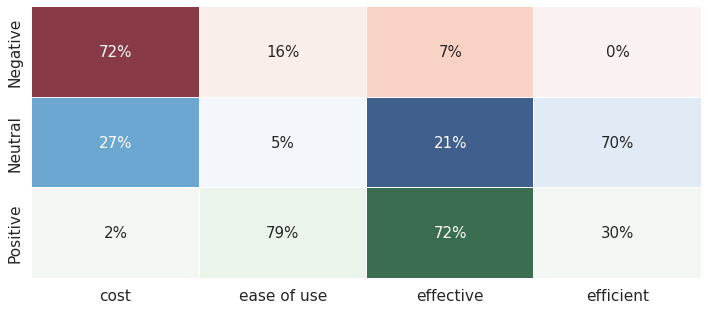

In [17]:
# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table_count.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [18]:
# Treemap
import plotly.express as px
from collections import defaultdict
data =  pd.DataFrame.from_dict(df)
fig = px.treemap(data, path=['sentiment_m', 'align_type'])

fig.data[0].textinfo = 'label+text+value'
fig.data[0]['textfont']['color'] = "white"
fig.data[0]['textfont']['size'] = 15
fig.data[0].textposition = 'middle center'

fig.layout.hovermode = False

fig.show()

# For 5 start rating reviews

In [19]:
df_5 = df[df['rating'] == 5]

Text(0.5, 1.0, 'Top 10 Products with 5 Ratings')

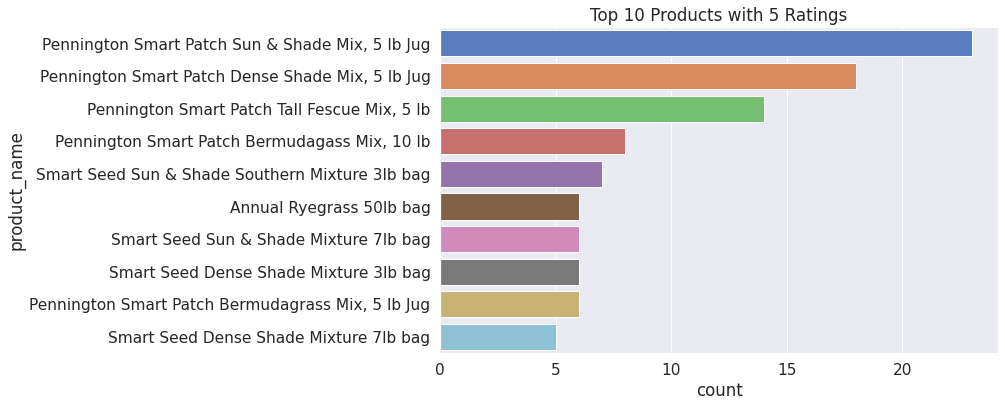

In [20]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 5 Ratings');
sns.countplot(y = 'product_name', data = df_5, order = df_5['product_name'].value_counts()[0:10].index, palette = "muted")
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

# N-gram

In [21]:
from collections import defaultdict
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)

In [22]:
## Get the bar chart from 5 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_5["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



# Heatmap

In [24]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df_5, values='max', index=['sentiment_m'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)

#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)


#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

<Figure size 864x360 with 0 Axes>

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

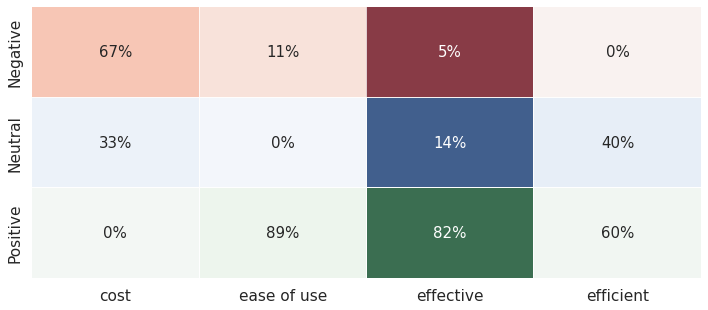

In [25]:
# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table_count.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# For 1 Star Rated Reviews

In [26]:
df_1 = df[df['rating'] == 1]

Text(0.5, 1.0, 'Top 10 Products with 1 Ratings')

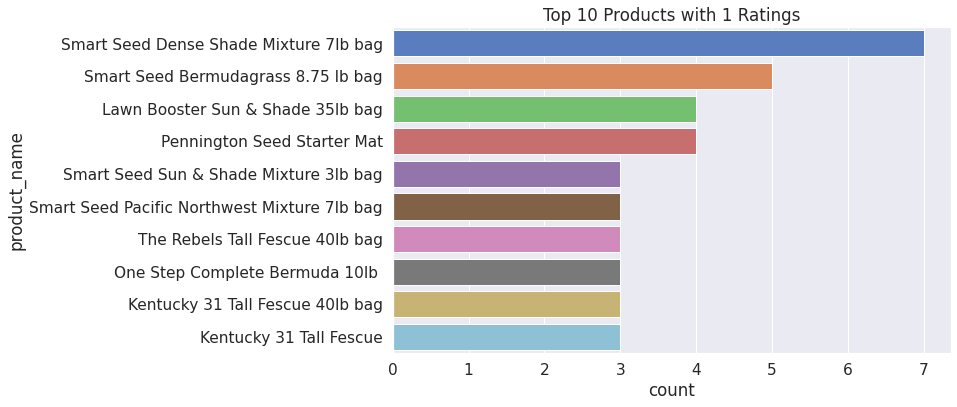

In [27]:
fig,ax = plt.subplots()
fig.set_size_inches(10,6)
plt.title('Top 10 Products with 1 Ratings');
sns.countplot(y = 'product_name', data = df_1, order = df_1['product_name'].value_counts()[0:10].index, palette = "muted")
#plt.savefig('figs/negative_homedepot', bbox_inches = 'tight');

In [28]:
## Get the bar chart from 1 rated reviews ##
freq_dict = defaultdict(int)
for sent in df_1["review_lower"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words"])
fig.append_trace(trace0, 1, 1)
#fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=600, width=600, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename='word-plots');

/usr/local/lib/python3.7/dist-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



In [ ]:
# Create Pivot table for the Heatmap
table_count = pd.pivot_table(df_1, values='max', index=['sentiment_m'], columns=['align_type'], aggfunc='count', margins=True, 
                       dropna=True, fill_value=0)

#count the percentage
table2 = table_count.div( table_count.iloc[-1,:], axis=1 ).applymap('{:.0%}'.format)
table2=table2.drop('All').drop(labels='All', axis=1)


#Drop "ALL" column and row
table_count=table_count.drop('All').drop(labels='All', axis=1)

#reshape results
results=np.asarray(table2)

<Figure size 864x360 with 0 Axes>

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

[Text(79.5, 0.5, ''), Text(0.5, 16.5, '')]

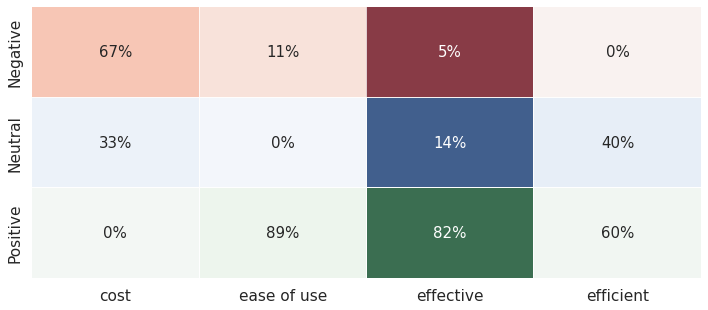

In [29]:
# Heatmap

plt.figure(figsize=(12, 5))
sns.set(font_scale=1.4)
# Reds
data1 = table_count.copy()
data1.loc['Negative'] = float('nan')
data1.loc['Neutral'] = float('nan')
ax=sns.heatmap(data1, annot=results, cmap="Greens",alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

# Blue
data2 = table_count.copy()
data2.loc['Negative'] = float('nan')
data2.loc['Positive'] = float('nan')
ax=sns.heatmap(data2, annot=results, cmap="Blues", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")
# Greens
data3 = table_count.copy()
data3.loc['Positive'] = float('nan')
data3.loc['Neutral'] = float('nan')
ax=sns.heatmap(data3, annot=results, cmap="Reds", alpha=0.75,fmt="",annot_kws={"fontsize":15},linewidth=0.1,cbar=False)
ax.set(xlabel="", ylabel="")

In [30]:
df.to_csv('evaluation_PenningtonGrass.csv')